##Documentação das funções implementadas.

Nesta sessão estão as células com as funções para realizar a leitura dos dados, extração de características, treinamento e teste dos modelos de classificação e para plotagem das análises de experimentos. Alguns detalhes de implementação serão apresentados em formato de texto e comentários.

###Importação de bibliotecas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import preprocessing
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score

###Funções para leitura de dados e extração de características.

Nesta sessão foram implementadas funções para realizar a leitura e a extração de características dos dados.

In [2]:
def leitura_dados(caminho, arquivos):
  caminho_scenario = caminho
  dfs_dados = []
  for arq in arquivos:
    df_scenario = pd.read_csv(caminho_scenario+arq)
    print(df_scenario.columns)
    
    if arq == "patients.csv":
      df_scenario.drop(['SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
        'SUFFIX', 'MAIDEN', 'MARITAL','HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'BIRTHPLACE', 'ADDRESS', 'STATE', 'CITY', 'COUNTY', 'ZIP'], axis=1, inplace=True)
    
    if arq == "encounters.csv":
      df_scenario.drop(['PAYER', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE'], axis=1, inplace=True)
      
    if arq == "conditions.csv":
      df_scenario.drop([], axis=1, inplace=True)
    
    if arq == "procedures.csv":
      df_scenario.drop([], axis=1, inplace=True)
    
    if arq == "medications.csv":
      df_scenario.drop([], axis=1, inplace=True)
    
    if arq == 'observations.csv':
      df_scenario.drop([], axis=1, inplace=True)
      
    print(df_scenario.columns)
    dfs_dados.append(df_scenario)
  
  return dfs_dados


In [3]:
def preparing_patients(df):
  RawData4ML_scenario = df.copy()
  RawData4ML_scenario = RawData4ML_scenario[['Id', 'BIRTHDATE', 'DEATHDATE', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON']]
  print(RawData4ML_scenario.sample())
  return RawData4ML_scenario

Função que retorna a contagem de interações entre o paciente e o sistema, dado o nome da váriavel (por exemplo, *conditions* e *procedures*).

In [4]:
def variavel_count(df, RawData4ML_scenario, nome):
  df_scenario_Count = df.groupby('PATIENT').size().reset_index(name=nome)
  df_scenario_Count.columns = ['Id',nome]

  RawData4ML_scenario = RawData4ML_scenario.merge(df_scenario_Count, how='left', on='Id')
  return RawData4ML_scenario


Função que atribui *False* para a váriavel "Dead" se não houver "DeathDate" registrado e *True*, caso contrário.

In [5]:
def variavel_mortalidade(RawData4ML_scenario):
  RawData4ML_scenario['Dead'] = 0
  RawData4ML_scenario['Dead'] = ~RawData4ML_scenario.DEATHDATE.isnull()
  RawData4ML_scenario.drop('DEATHDATE', axis=1, inplace=True)
  RawData4ML_scenario.Dead.value_counts(normalize=True)

  return RawData4ML_scenario

Função que trata "RACE", "ETHNICITY", "GENDER" e "BIRTHDATE" (transformação para idade) como variáveis categóricas.

In [6]:
def variavel_categorica(RawData4ML_scenario):
  print(RawData4ML_scenario.shape)
  columns = ['RACE', 'ETHNICITY']

  RawData4ML_scenario = pd.get_dummies(RawData4ML_scenario, columns = columns)
  print(RawData4ML_scenario.shape)
  print(RawData4ML_scenario.isnull().sum())

  RawData4ML_scenario['GENDER']=RawData4ML_scenario['GENDER'].apply(lambda x: 1 if x =='M'  else 0)
  RawData4ML_scenario.fillna(value=0, inplace=True)
  RawData4ML_scenario.isnull().sum()

  RawData4ML_scenario['BIRTHDATE'] = pd.to_datetime(RawData4ML_scenario['BIRTHDATE'])
  now = pd.to_datetime('now')
  RawData4ML_scenario['Age'] = (now - RawData4ML_scenario['BIRTHDATE']).astype('<m8[Y]') 
  RawData4ML_scenario.drop('BIRTHDATE', axis=1, inplace=True)

  return RawData4ML_scenario

Função que retorna a variável "Dead" como *labels* para o treinamento supervisionado a ser realizado e as demais variáveis entrada para o modelo a ser criado.

In [7]:
def separacao_dados(RawData4ML_scenario):
  y_scenario = RawData4ML_scenario.Dead.values
  print(y_scenario.shape)
  X_scenario = RawData4ML_scenario.drop(['Dead','Id'], axis=1)
  print(X_scenario.shape)

  x_scenario = X_scenario.values 
  scaler = preprocessing.StandardScaler()
  x_scenario_scaled = scaler.fit_transform(x_scenario)
  X_scenario = pd.DataFrame(x_scenario_scaled, columns=X_scenario.columns)

  print(X_scenario.shape)
  X_scenario.tail(1)
  return X_scenario, y_scenario

In [8]:
def pre_feature_conditions(df_scenario):
  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.replace('(', '')
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.replace(')', '')
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)
  return df_scenario

In [9]:
def pre_feature_medications(df_scenario):
  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  df_scenario['START'] = pd.to_datetime(df_scenario['START'])
  df_scenario = df_scenario[df_scenario.STOP.isnull()]
  print(df_scenario.shape)
  df_scenario.sample(1)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)
  return df_scenario

In [10]:
def pre_feature(df_scenario):
  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  print(df_scenario.shape)
  df_scenario.sample(1)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)
  return df_scenario

Funções para preparar as features a serem concatenadas. A preparação é feita da seguinte forma:

1.   Organização em ordem decrescente: escolher apenas os últimos, *n* mais recentes;
2.   Concatenar palavras em conceitos: por exemplo, sinusite crônica = sinusite_crônica;
3.   Remover duplicações;
4.   Tokenização;
5.   Vetorização em uma dimensão.





In [11]:
def token_feature_conditions(df_scenario, RawData4ML_scenario, numFeat):
  '''
  Organização em ordem decrescente.
  '''

  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.replace('(', '')
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.replace(')', '')
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)

  '''
  Concatenar palavras em conceitos.
  '''
  scenario_conditionsGr = df_scenario.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
  scenario_conditionsGr.columns = ['Id','Conditions']
  scenario_conditionsGr.head()
  RawData4ML_scenario = RawData4ML_scenario.merge(scenario_conditionsGr, how='left', on='Id')

  '''
  Remover duplicações.
  '''
  RawData4ML_scenario['Conditions'] = (RawData4ML_scenario['Conditions'].astype(str).str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  texts = RawData4ML_scenario['Conditions'].astype(str).tolist()
  print(len(texts))
  maxlen = numFeat 
  max_words = 200 
  max_features = max_words

  '''
  Tokenização.
  '''

  # Tokenização de palavras para inteiros (sequências). Remover sublinhado, ponto e menos (-).

  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)
  print(data.shape)

  rowNum = 123
  print(texts[rowNum])
  print(sequences[rowNum])
  print(data[rowNum])
  Emodel = Sequential()
  Emodel.add(Embedding(max_features, 1, input_length=maxlen))
  output_array = Emodel.predict(data)
  print(output_array.shape)
  embeddings = Emodel.layers[0].get_weights()[0]
  print(embeddings.shape)
  rowNum=0
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  fromVsequences = []

  for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: 
        fromVsequences.append(wordInteger)

  Vdecoded_review = ' '.join(
  [reverse_word_index.get(i) for i in fromVsequences])
  print(texts[rowNum])
  print(sequences[rowNum])
  print(data[rowNum])
  print(output_array[rowNum])
  print(Vdecoded_review)

  '''
  Vetorização em uma dimensão.
  '''
  VectFeat = []
  for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())
  VectFeat = pd.DataFrame(VectFeat)
  print(VectFeat.shape)
  VectFeat.columns=["Condition"+str(i) for i in range(0, numFeat)]
  VectFeat

  return VectFeat, RawData4ML_scenario

In [12]:
def token_feature_medications(df_scenario, RawData4ML_scenario, label, numFeat, max_words):

  # Apenas medicações que não pararam.

  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  df_scenario['START'] = pd.to_datetime(df_scenario['START'])
  df_scenario = df_scenario[df_scenario.STOP.isnull()]
  print(df_scenario.shape)
  df_scenario.sample(1)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)

  scenario_Gr = df_scenario.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
  scenario_Gr.columns = ['Id', label]
  RawData4ML_scenario = RawData4ML_scenario.merge(scenario_Gr, how='left', on='Id')
  RawData4ML_scenario[label] = (RawData4ML_scenario[label].astype(str).str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  RawData4ML_scenario.head(1)

  texts = RawData4ML_scenario[label].astype(str).tolist()
  print(len(texts))
  maxlen = numFeat 
  max_features = max_words
  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)
  print(data.shape)

  rowNum=112
  Emodel = Sequential()
  Emodel.add(Embedding(max_features, 1, input_length=maxlen))
  output_array = Emodel.predict(data)
  print(output_array.shape)
  embeddings = Emodel.layers[0].get_weights()[0]
  print(embeddings.shape)
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  fromVsequences = []

  for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: 
        fromVsequences.append(wordInteger)

  Vdecoded_review = ' '.join(
  [reverse_word_index.get(i) for i in fromVsequences])
  print(texts[rowNum])
  print(Vdecoded_review)
  VectFeat = []
  for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())
  VectFeat = pd.DataFrame(VectFeat)
  print(VectFeat.shape)
  VectFeat.columns=[label+str(i) for i in range(0, numFeat)]
  VectFeat
  return VectFeat, RawData4ML_scenario

In [13]:
def token_feature_observations(df_scenario, RawData4ML_scenario, label, numFeat, max_words):
  max_words = 49000 

  print(df_scenario.shape)
  df_scenario['DATE'] = pd.to_datetime(df_scenario['DATE'])
  df_scenario['DescVal'] = df_scenario.DESCRIPTION.astype(str) +'_'+ df_scenario.VALUE.astype(str)
  print(df_scenario.shape)
  df_scenario.sort_values(by =['PATIENT', 'DATE'],ascending=False, inplace=True)
  df_scenario.head()
  df_scenario.DescVal = df_scenario.DescVal.str.lower()
  df_scenario.DescVal = df_scenario.DescVal.replace(' ', '_', regex=True)

  scenario_Gr = df_scenario.groupby('PATIENT')['DescVal'].apply(lambda x: ' '.join(x)).reset_index()
  scenario_Gr.columns = ['Id', label]
  RawData4ML_scenario = RawData4ML_scenario.merge(scenario_Gr, how='left', on='Id')
  RawData4ML_scenario[label] = (RawData4ML_scenario[label].astype(str).str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  RawData4ML_scenario.head(1)

  texts = RawData4ML_scenario[label].astype(str).tolist()
  print(len(texts))
  maxlen = numFeat 
  max_features = max_words
  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)
  print(data.shape)

  rowNum=112
  Emodel = Sequential()
  Emodel.add(Embedding(max_features, 1, input_length=maxlen))
  output_array = Emodel.predict(data)
  print(output_array.shape)
  embeddings = Emodel.layers[0].get_weights()[0]
  print(embeddings.shape)
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  fromVsequences = []

  for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: 
        fromVsequences.append(wordInteger)

  Vdecoded_review = ' '.join(
  [reverse_word_index.get(i) for i in fromVsequences])
  print(texts[rowNum])
  print(Vdecoded_review)
  VectFeat = []
  for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())
  VectFeat = pd.DataFrame(VectFeat)
  print(VectFeat.shape)
  VectFeat.columns=[label+str(i) for i in range(0, numFeat)]
  VectFeat
  return VectFeat, RawData4ML_scenario

In [14]:
def token_feature(df_scenario, RawData4ML_scenario, label, numFeat, max_words):
  
  df_scenario.sort_values(by =['PATIENT', 'START'],ascending=False, inplace=True)
  print(df_scenario.shape)
  df_scenario.sample(1)
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.str.lower()
  df_scenario.DESCRIPTION = df_scenario.DESCRIPTION.replace(' ', '_', regex=True)

  scenario_Gr = df_scenario.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
  scenario_Gr.columns = ['Id', label]
  RawData4ML_scenario = RawData4ML_scenario.merge(scenario_Gr, how='left', on='Id')
  RawData4ML_scenario[label] = (RawData4ML_scenario[label].astype(str).str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  RawData4ML_scenario.head(1)

  texts = RawData4ML_scenario[label].astype(str).tolist()
  print(len(texts))
  maxlen = numFeat 
  max_features = max_words
  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)
  print(data.shape)

  rowNum=112
  Emodel = Sequential()
  Emodel.add(Embedding(max_features, 1, input_length=maxlen))
  output_array = Emodel.predict(data)
  print(output_array.shape)
  embeddings = Emodel.layers[0].get_weights()[0]
  print(embeddings.shape)
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  fromVsequences = []

  for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: 
        fromVsequences.append(wordInteger)

  Vdecoded_review = ' '.join(
  [reverse_word_index.get(i) for i in fromVsequences])
  print(texts[rowNum])
  print(Vdecoded_review)
  VectFeat = []
  for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())
  VectFeat = pd.DataFrame(VectFeat)
  print(VectFeat.shape)
  VectFeat.columns=[label+str(i) for i in range(0, numFeat)]
  VectFeat
  return VectFeat, RawData4ML_scenario

In [15]:
def token_feature_sem(df_scenario, RawData4ML_scenario, label, numFeat, max_words):
  scenario_Gr = df_scenario.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ' '.join(x)).reset_index()
  scenario_Gr.columns = ['Id', label]
  RawData4ML_scenario = RawData4ML_scenario.merge(scenario_Gr, how='left', on='Id')
  RawData4ML_scenario[label] = (RawData4ML_scenario[label].astype(str).str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
  RawData4ML_scenario.head(1)

  texts = RawData4ML_scenario[label].astype(str).tolist()
  print(len(texts))
  maxlen = numFeat 
  max_features = max_words
  tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,/:;<=>?@[\\]^`{|}~\t\n',)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0.0)
  print(data.shape)

  rowNum=112
  Emodel = Sequential()
  Emodel.add(Embedding(max_features, 1, input_length=maxlen))
  output_array = Emodel.predict(data)
  print(output_array.shape)
  embeddings = Emodel.layers[0].get_weights()[0]
  print(embeddings.shape)
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  fromVsequences = []

  for wordNum in range(len(output_array[rowNum])):
    itemindex = np.where(embeddings == output_array[rowNum][wordNum])
    wordInteger = itemindex[0][0]
    if wordInteger != 0: 
        fromVsequences.append(wordInteger)

  Vdecoded_review = ' '.join(
  [reverse_word_index.get(i) for i in fromVsequences])
  print(texts[rowNum])
  print(Vdecoded_review)
  VectFeat = []
  for rowNum in range(output_array.shape[0]):
    VectFeat.append(output_array[rowNum].flatten())
  VectFeat = pd.DataFrame(VectFeat)
  print(VectFeat.shape)
  VectFeat.columns=[label+str(i) for i in range(0, numFeat)]
  VectFeat
  return VectFeat, RawData4ML_scenario

Função para adicionar vetores às demais *features*. 

In [16]:
def concatenar_feature(X_scenario, VectFeat):

  # Adiciona os vetores como features para RF (aprendizagem de representação).
  print(X_scenario.shape)
  X_scenario = pd.concat([X_scenario, VectFeat], axis=1)
  print(X_scenario.shape)
  X_scenario.head(1)

  return X_scenario

###Funções para dividir os conjuntos de treinamento e de teste e para calcular as métricas da classificação dos modelos testados.

In [17]:
def training_and_testing(X, y, model, test_size):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  return X_train, X_test, y_train, y_test, preds

In [18]:
def training_and_testing_2bases(X01, y01, X02, y02, model, test_size):

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  model.fit(X01, y01)
  preds = model.predict(X02)
  return X01, X02, y01, y02, preds

In [19]:
def verifica_overfitting(X, y, model, test_size):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  model.fit(X_train, y_train)
  preds = model.predict(X_train)
  return X_train, X_test, y_train, y_test, preds

A seguinte função retorna 

*   verdadeiros negativos,
*   falsos positivos,
*   falsos negativos,
*   verdadeiros positivos,
*   precisão, 
*   *recall*, 
*   acurácia, 
*   *F1 score* e 
*   acurácia balanceada,

dadas as labels do conjunto de teste e as predições realizadas por um modelo de classificação.

In [20]:
def metrics(y_test, preds):
  CM = confusion_matrix(y_test, preds)
  #print(classification_report(y_test, preds))
  tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
  '''
  print(CM)
  print("_"*50)
  print("TP ", tp)
  print("FP ", fp)
  print("TN ", tn)
  print("FN ", fn)
  '''
  precision = round(precision_score(y_test, preds),3)
  recall  = round(recall_score(y_test, preds),3 )
  accuracy = round(accuracy_score(y_test, preds),3)
  F1_score = round(f1_score(y_test, preds),3)
  acc_balanced = round(balanced_accuracy_score(y_test, preds),3)

  return tn, fp, fn, tp, precision, recall, accuracy, F1_score, acc_balanced

A seguinte função é um script para calcular *n* vezes as métricas da função acima e obter a média e desvio padrão desses cálculos.

In [21]:
def script(trial_count, X, y, model, test_size):
  tns = []
  fps = []
  fns = [] 
  tps = []
  precisions = []
  recalls = []
  accuracys = []
  F1_scores = []
  acc_balanceds = []
  for i in range(trial_count):
    X_train, X_test, y_train, y_test, preds = training_and_testing(X, y, model, test_size)
    tn, fp, fn, tp, precision, recall, accuracy, F1_score, acc_balanced = metrics(y_test, preds)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)
    F1_scores.append(F1_score)
    acc_balanceds.append(acc_balanced)

  tn_mean = np.mean(tns)
  fp_mean = np.mean(fps)
  fn_mean = np.mean(fns)
  tp_mean = np.mean(tps)
  precision_mean = np.mean(precisions)
  recall_mean = np.mean(recalls)
  accuracy_mean = np.mean(accuracys)
  F1_score_mean = np.mean(F1_scores)
  acc_balanced_mean = np.mean(acc_balanceds)
  '''
  print(tn_mean, np.std(tns))
  print(fp_mean, np.std(fps))
  print(fn_mean, np.std(fns))
  print(tp_mean, np.std(tps))
  print(precision_mean, np.std(precisions))
  print(recall_mean, np.std(recalls))
  print(F1_score_mean, np.std(F1_scores))
  print(accuracy_mean, np.std(accuracys))
  print(acc_balanced_mean, np.std(acc_balanceds))
  '''
  return round(tn_mean,3), round(np.std(tns),3), round(fp_mean,3), round(np.std(fps),3), round(fn_mean,3), round(np.std(fns),3), round(tp_mean,3), round(np.std(tps),3), round(precision_mean,3), round(np.std(precisions),3),  round(recall_mean,3), round(np.std(recalls),3), round(F1_score_mean,3), round(np.std(F1_scores),3), round(accuracy_mean,3), round(np.std(accuracys),3), round(acc_balanced_mean,3), round(np.std(acc_balanceds),3)

In [22]:
def script_2bases(trial_count, X01, y01,X02,y02, model, test_size):
  tns = []
  fps = []
  fns = [] 
  tps = []
  precisions = []
  recalls = []
  accuracys = []
  F1_scores = []
  acc_balanceds = []
  for i in range(trial_count):
    X_train, X_test, y_train, y_test, preds = training_and_testing_2bases(X01, y01, X02,y02, model, test_size)
    tn, fp, fn, tp, precision, recall, accuracy, F1_score, acc_balanced = metrics(y_test, preds)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)
    F1_scores.append(F1_score)
    acc_balanceds.append(acc_balanced)

  tn_mean = np.mean(tns)
  fp_mean = np.mean(fps)
  fn_mean = np.mean(fns)
  tp_mean = np.mean(tps)
  precision_mean = np.mean(precisions)
  recall_mean = np.mean(recalls)
  accuracy_mean = np.mean(accuracys)
  F1_score_mean = np.mean(F1_scores)
  acc_balanced_mean = np.mean(acc_balanceds)
  '''
  print(tn_mean, np.std(tns))
  print(fp_mean, np.std(fps))
  print(fn_mean, np.std(fns))
  print(tp_mean, np.std(tps))
  print(precision_mean, np.std(precisions))
  print(recall_mean, np.std(recalls))
  print(F1_score_mean, np.std(F1_scores))
  print(accuracy_mean, np.std(accuracys))
  print(acc_balanced_mean, np.std(acc_balanceds))
  '''
  return round(tn_mean,3), round(np.std(tns),3), round(fp_mean,3), round(np.std(fps),3), round(fn_mean,3), round(np.std(fns),3), round(tp_mean,3), round(np.std(tps),3), round(precision_mean,3), round(np.std(precisions),3),  round(recall_mean,3), round(np.std(recalls),3), round(F1_score_mean,3), round(np.std(F1_scores),3), round(accuracy_mean,3), round(np.std(accuracys),3), round(acc_balanced_mean,3), round(np.std(acc_balanceds),3)

A seguinte função realiza os mesmo comandos que a anterior, mas os testes são feitos com o conjunto de treinamento para verificar se o modelo está com *overfitting*.

In [23]:
def script_overfitting(trial_count, X, y, model, test_size):
  tns = []
  fps = []
  fns = [] 
  tps = []
  precisions = []
  recalls = []
  accuracys = []
  F1_scores = []
  acc_balanceds = []
  for i in range(trial_count):
    X_train, X_test, y_train, y_test, preds = verifica_overfitting(X, y, model, test_size)
    tn, fp, fn, tp, precision, recall, accuracy, F1_score, acc_balanced = metrics(y_train, preds)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)
    F1_scores.append(F1_score)
    acc_balanceds.append(acc_balanced)

  tn_mean = np.mean(tns)
  fp_mean = np.mean(fps)
  fn_mean = np.mean(fns)
  tp_mean = np.mean(tps)
  precision_mean = np.mean(precisions)
  recall_mean = np.mean(recalls)
  accuracy_mean = np.mean(accuracys)
  F1_score_mean = np.mean(F1_scores)
  acc_balanced_mean = np.mean(acc_balanceds)
  
  print(tn_mean, np.std(tns))
  print(fp_mean, np.std(fps))
  print(fn_mean, np.std(fns))
  print(tp_mean, np.std(tps))
  print(precision_mean, np.std(precisions))
  print(recall_mean, np.std(recalls))
  print(F1_score_mean, np.std(F1_scores))
  print(accuracy_mean, np.std(accuracys))
  print(acc_balanced_mean, np.std(acc_balanceds))
  
  return tn_mean, np.std(tns), fp_mean, np.std(fps), fn_mean, np.std(fns), tp_mean, np.std(tps), precision_mean, np.std(precisions),  recall_mean, np.std(recalls), F1_score_mean, np.std(F1_scores), accuracy_mean, np.std(accuracys), acc_balanced_mean, np.std(acc_balanceds)

In [24]:
def metrics_model(test_sizes, models, trial_count, X_scenario, y_scenario):
  metrics_model = []
  metrics_test_size = []
  for model in models:
    print(model)
    for test_s in test_sizes:
      print(test_s)
    
      metrics_test_size.append(script(trial_count, X_scenario, y_scenario, model, test_s))
  
    metrics_model.append(metrics_test_size)
    metrics_test_size = []
  return metrics_model

In [25]:
def metrics_model_2bases(test_sizes, models, trial_count, X_scenario, y_scenario, X_scenario02, y_scenario02):
  metrics_model = []
  metrics_test_size = []
  for model in models:
    print(model)
    for test_s in test_sizes:
      print(test_s)
    
      metrics_test_size.append(script_2bases(trial_count, X_scenario, y_scenario, X_scenario02, y_scenario02,model, test_s))
  
    metrics_model.append(metrics_test_size)
    metrics_test_size = []
  return metrics_model

###Plots

As funções desta sessão têm como objetivo plotar gráficos das análises que serão discutidas na sessão de análise de resultados.

In [26]:
def testes_2bases(caminho_scenario01, caminho_scenario02):
  arquivos = ['patients.csv', 'encounters.csv', 'conditions.csv', 'procedures.csv', 'medications.csv', 'observations.csv']
  numerosFeatures = [10, 20, 30]
  models = [RandomForestClassifier(class_weight = 'balanced'), LogisticRegression(class_weight = 'balanced')]
  test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

  trial_count = 10

  metrics_numFeat_model = []
  for numFeat in numerosFeatures:
    RawData4ML_scenario = []
    df_dados = leitura_dados(caminho_scenario01, arquivos)
    RawData4ML_scenario = preparing_patients(df_dados[0])

    RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumEncounters")
    RawData4ML_scenario = variavel_count(df_dados[2], RawData4ML_scenario, "NumConditions")
    RawData4ML_scenario = variavel_count(df_dados[3], RawData4ML_scenario, "NumProcedures")
    RawData4ML_scenario = variavel_count(df_dados[4], RawData4ML_scenario, "NumMedications")
    RawData4ML_scenario = variavel_count(df_dados[5], RawData4ML_scenario, "NumObservations")
    RawData4ML_scenario = variavel_mortalidade(RawData4ML_scenario)
    RawData4ML_scenario = variavel_categorica(RawData4ML_scenario)

    X_scenario, y_scenario = separacao_dados(RawData4ML_scenario)

    VectFeat, RawData4ML_scenario = token_feature_conditions(df_dados[2], RawData4ML_scenario, numFeat)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature(df_dados[1], RawData4ML_scenario, 'Encounters', numFeat, 62)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature(df_dados[3], RawData4ML_scenario, 'Procedures', numFeat, 200)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature_medications(df_dados[4], RawData4ML_scenario, 'Medications', numFeat, 160)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature_observations(df_dados[5], RawData4ML_scenario, 'Observations', numFeat, 49000)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    
    df_dados02 = leitura_dados(caminho_scenario02, arquivos)
    RawData4ML_scenario02 = preparing_patients(df_dados02[0])

    RawData4ML_scenario02 = variavel_count(df_dados02[1], RawData4ML_scenario02, "NumEncounters")
    RawData4ML_scenario02 = variavel_count(df_dados02[2], RawData4ML_scenario02, "NumConditions")
    RawData4ML_scenario02 = variavel_count(df_dados02[3], RawData4ML_scenario02, "NumProcedures")
    RawData4ML_scenario02 = variavel_count(df_dados02[4], RawData4ML_scenario02, "NumMedications")
    RawData4ML_scenario02 = variavel_count(df_dados02[5], RawData4ML_scenario02, "NumObservations")
    RawData4ML_scenario02 = variavel_mortalidade(RawData4ML_scenario02)
    RawData4ML_scenario02 = variavel_categorica(RawData4ML_scenario02)

    X_scenario02, y_scenario02 = separacao_dados(RawData4ML_scenario02)


    VectFeat02, RawData4ML_scenario02 = token_feature_conditions(df_dados02[2], RawData4ML_scenario02, numFeat)
    X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

    VectFeat02, RawData4ML_scenario02 = token_feature(df_dados02[1], RawData4ML_scenario02, 'Encounters', numFeat, 62)
    X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

    VectFeat02, RawData4ML_scenario02 = token_feature(df_dados02[3], RawData4ML_scenario02, 'Procedures', numFeat, 200)
    X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

    VectFeat02, RawData4ML_scenario02 = token_feature_medications(df_dados02[4], RawData4ML_scenario02, 'Medications', numFeat, 160)
    X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

    VectFeat02, RawData4ML_scenario02 = token_feature_observations(df_dados02[5], RawData4ML_scenario02, 'Observations', numFeat, 49000)
    X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

    metrics_model_features = metrics_model_2bases(test_sizes, models, trial_count, X_scenario, y_scenario,X_scenario02, y_scenario02)
    metrics_numFeat_model.append(metrics_model_features)
  return metrics_numFeat_model

In [27]:
def testes(caminho_scenario01):
  arquivos = ['patients.csv', 'encounters.csv', 'conditions.csv', 'procedures.csv', 'medications.csv', 'observations.csv']
  numerosFeatures = [10, 20, 30]
  models = [RandomForestClassifier(class_weight = 'balanced'), LogisticRegression(class_weight = 'balanced')]
  test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

  trial_count = 10

  metrics_numFeat_model = []
  for numFeat in numerosFeatures:
    RawData4ML_scenario = []
    df_dados = leitura_dados(caminho_scenario01, arquivos)
    RawData4ML_scenario = preparing_patients(df_dados[0])

    RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumEncounters")
    RawData4ML_scenario = variavel_count(df_dados[2], RawData4ML_scenario, "NumConditions")
    RawData4ML_scenario = variavel_count(df_dados[3], RawData4ML_scenario, "NumProcedures")
    RawData4ML_scenario = variavel_count(df_dados[4], RawData4ML_scenario, "NumMedications")
    RawData4ML_scenario = variavel_count(df_dados[5], RawData4ML_scenario, "NumObservations")
    RawData4ML_scenario = variavel_mortalidade(RawData4ML_scenario)
    RawData4ML_scenario = variavel_categorica(RawData4ML_scenario)

    X_scenario, y_scenario = separacao_dados(RawData4ML_scenario)



    VectFeat, RawData4ML_scenario = token_feature_conditions(df_dados[2], RawData4ML_scenario, numFeat)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

  
    VectFeat, RawData4ML_scenario = token_feature(df_dados[1], RawData4ML_scenario, 'Encounters', numFeat, 62)
    X_scenario = concatenar_feature(X_scenario, VectFeat)
    
    VectFeat, RawData4ML_scenario = token_feature(df_dados[3], RawData4ML_scenario, 'Procedures', numFeat, 200)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature_medications(df_dados[4], RawData4ML_scenario, 'Medications', numFeat, 160)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    VectFeat, RawData4ML_scenario = token_feature_observations(df_dados[5], RawData4ML_scenario, 'Observations', numFeat, 49000)
    X_scenario = concatenar_feature(X_scenario, VectFeat)

    metrics_model_features = metrics_model(test_sizes, models, trial_count, X_scenario, y_scenario)
    
    metrics_numFeat_model.append(metrics_model_features)
  return metrics_numFeat_model

As funções abaixo plotam gráficos que serão chamadas na análise dos resultados.

In [28]:
def plotar_acc_acc_blcd(num_features, df_10, df_20, df_30, index, titulo):
  sn.reset_orig()
  #tn_mean, fp_mean, fn_mean, tp_mean, precision_mean, recall_mean, F1_score_mean, accuracy_mean, acc_balanced_mean
  x = np.arange(3) 
  width = 0.2
  accs = [df_10['accuracy_mean'][index], df_20['accuracy_mean'][index], df_30['accuracy_mean'][index]]
  accs_blcd = [df_10['acc_balanced_mean'][index], df_20['acc_balanced_mean'][index], df_30['acc_balanced_mean'][index]]

  plt.bar(x- width, accs, width, color='cyan') 
  plt.bar(x, accs_blcd, width, color='orange') 
  plt.xticks(x, ['10','20','30']) 
  plt.xlabel("Número de features") 
  plt.ylabel("Acurácia e acurácia balanceada") 
  plt.legend(["Acurácia", "Acurácia balanceada"], bbox_to_anchor=(1, 1)) 
  plt.title(titulo)
  plt.show() 

In [29]:
def plotar_acc_acc_blcd(num_features, df_20, titulo):
  sn.reset_orig()
  #tn_mean, fp_mean, fn_mean, tp_mean, precision_mean, recall_mean, F1_score_mean, accuracy_mean, acc_balanced_mean
  x = np.arange(3) 
  width = 0.2
  accs = df_20['accuracy_mean']
  accs_blcd =  df_20['acc_balanced_mean']

  plt.bar(x- width, accs, width, color='cyan') 
  plt.bar(x, accs_blcd, width, color='orange') 
  plt.xticks(x, ['10','20','30']) 
  plt.xlabel("Número de features") 
  plt.ylabel("Acurácia e acurácia balanceada") 
  plt.legend(["Acurácia", "Acurácia balanceada"], bbox_to_anchor=(1, 1)) 
  plt.title(titulo)
  plt.show() 

In [30]:
def plotar_testSize_accblcd(test_sizes, metrics_model, titulo):
  sn.reset_orig()
  #tn_mean, fp_mean, fn_mean, tp_mean, precision_mean, recall_mean, F1_score_mean, accuracy_mean, acc_balanced_mean
  x = np.arange(5) 
  width = 0.2
  blc_accs = []
  accs = []
  tn_means = []
  fp_means = []
  fn_means = []
  tp_means = []
  precision_means = []
  recall_means = []
  F1_score_means = []
  accuracy_means = []
  for i in range(len(test_sizes)):
    blc_accs.append(metrics_model[0][i][16])

  print(blc_accs)
  plt.bar(x - 0.2, blc_accs, width, color='cyan') 
  blc_accs = []
  for i in range(len(test_sizes)):
    blc_accs.append(metrics_model[1][i][16])

  print(blc_accs)
  plt.bar(x, blc_accs, width, color='orange') 
  plt.xticks(x, ['0.20', '0.25', '0.30', '0.35', '0.40']) 
  plt.xlabel("Tamanho do conjunto de teste") 
  plt.ylabel("Acurácia balanceada") 
  plt.legend(["Random Forest", "Regressão Logística"], bbox_to_anchor=(1, 1)) 
  plt.title(titulo)
  plt.show() 
  

In [31]:
def plotar_testSize_accblcd_1modelo(test_sizes, metrics_model, legenda, titulo):
  sn.reset_orig()
  x = np.arange(5) 

  width = 0.2
  blc_accs = []
  for i in range(len(test_sizes)):
    blc_accs.append(metrics_model[0][i][8])

  print(blc_accs)
  plt.bar(x, blc_accs, width, color='cyan') 
  plt.xticks(x, ['0.20', '0.25', '0.30', '0.35', '0.40']) 
  plt.xlabel("Tamanho do conjunto de teste") 
  plt.ylabel("Acurácia balanceada") 
  plt.legend([legenda], bbox_to_anchor=(1, 1)) 
  plt.title(titulo)
  plt.show() 

In [32]:
def plot_matriz_confusao(matriz_confusao):
  df_cm = pd.DataFrame(matriz_confusao, range(2), range(2))
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='.2f')
  plt.show()

##Testes

Experimento com os arquivos separadamente para extrair features

In [35]:
caminho_scenario01 = '/content/drive/MyDrive/2022-1Semestre/Ciencia-Dados-Saude/trabalho2/data/external/synthea/scenario01/csv/'
arquivos = ['patients.csv', 'observations.csv']
#arquivos = ['patients.csv', 'encounters.csv', , 'procedures.csv', 'medications.csv', 'observations.csv']

df_dados = leitura_dados(caminho_scenario01, arquivos)
RawData4ML_scenario = preparing_patients(df_dados[0])
'''
RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumEncounters")

RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumConditions")

RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumProcedures")

RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumMedications")
'''
RawData4ML_scenario = variavel_count(df_dados[1], RawData4ML_scenario, "NumObservations")

RawData4ML_scenario = variavel_mortalidade(RawData4ML_scenario)
RawData4ML_scenario = variavel_categorica(RawData4ML_scenario)

X_scenario, y_scenario = separacao_dados(RawData4ML_scenario)

numFeat = 20

#df_conditions = pre_feature_conditions(df_dados[2])
#VectFeat = token_feature(df_conditions, RawData4ML_scenario, 'Conditions',numFeat, 200)
'''
VectFeat, RawData4ML_scenario = token_feature_conditions(df_dados[1], RawData4ML_scenario, numFeat)
X_scenario = concatenar_feature(X_scenario, VectFeat)


#df_encounters = pre_feature(df_dados[1])
VectFeat, RawData4ML_scenario = token_feature(df_dados[1], RawData4ML_scenario, 'Encounters', numFeat, 62)
X_scenario = concatenar_feature(X_scenario, VectFeat)

#df_procedures = pre_feature(df_dados[3])
VectFeat, RawData4ML_scenario = token_feature(df_dados[1], RawData4ML_scenario, 'Procedures', numFeat, 200)
X_scenario = concatenar_feature(X_scenario, VectFeat)

VectFeat, RawData4ML_scenario = token_feature_medications(df_dados[1], RawData4ML_scenario, 'Medications', numFeat, 160)
X_scenario = concatenar_feature(X_scenario, VectFeat)
'''
VectFeat, RawData4ML_scenario = token_feature_observations(df_dados[1], RawData4ML_scenario, 'Observations', numFeat, 49000)
X_scenario = concatenar_feature(X_scenario, VectFeat)


Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION',
       'VALUE', 'UNITS', 'TYPE'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION',
       'VALUE', 'UNITS', 'TYPE'],
      dtype='object')
                                       Id   BIRTHDATE DEATHDATE   RACE  \
195  afd67caa-8c81-8f99-4070-264754d7f7d7  1982-02-22       NaN  white   

       ETHNICITY GENDER        LAT        LON  
195  nonhispanic      M  42.444239 -73.252875  
(1174, 9)
(1174, 15)
Id                    

In [29]:
caminho_scenario02 = '/content/drive/MyDrive/2022-1Semestre/Ciencia-Dados-Saude/trabalho2/data/external/synthea/scenario02/csv/'
arquivos = ['patients.csv', 'encounters.csv', 'conditions.csv', 'procedures.csv', 'medications.csv', 'observations.csv']

df_dados02 = leitura_dados(caminho_scenario02, arquivos)
RawData4ML_scenario02 = preparing_patients(df_dados02[0])

RawData4ML_scenario02 = variavel_count(df_dados02[1], RawData4ML_scenario02, "NumEncounters")
RawData4ML_scenario02 = variavel_count(df_dados02[2], RawData4ML_scenario02, "NumConditions")
RawData4ML_scenario02 = variavel_count(df_dados02[3], RawData4ML_scenario02, "NumProcedures")
RawData4ML_scenario02 = variavel_count(df_dados02[4], RawData4ML_scenario02, "NumMedications")
RawData4ML_scenario02 = variavel_count(df_dados02[5], RawData4ML_scenario02, "NumObservations")
RawData4ML_scenario02 = variavel_mortalidade(RawData4ML_scenario02)
RawData4ML_scenario02 = variavel_categorica(RawData4ML_scenario02)

X_scenario02, y_scenario02 = separacao_dados(RawData4ML_scenario02)

numFeat = 20

#df_conditions = pre_feature_conditions(df_dados[2])
#VectFeat = token_feature(df_conditions, RawData4ML_scenario, 'Conditions',numFeat, 200)
VectFeat02, RawData4ML_scenario02 = token_feature_conditions(df_dados02[2], RawData4ML_scenario02, numFeat)
X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

#df_encounters = pre_feature(df_dados[1])
VectFeat02, RawData4ML_scenario02 = token_feature(df_dados02[1], RawData4ML_scenario02, 'Encounters', numFeat, 62)
X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

#df_procedures = pre_feature(df_dados[3])
VectFeat02, RawData4ML_scenario02 = token_feature(df_dados02[3], RawData4ML_scenario02, 'Procedures', numFeat, 200)
X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

VectFeat02, RawData4ML_scenario02 = token_feature_medications(df_dados02[4], RawData4ML_scenario02, 'Medications', numFeat, 160)
X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

VectFeat02, RawData4ML_scenario02 = token_feature_observations(df_dados02[5], RawData4ML_scenario02, 'Observations', numFeat, 49000)
X_scenario02 = concatenar_feature(X_scenario02, VectFeat02)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
Index(['START', 'ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 20)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0]
(1121, 20, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[[-0.01070821]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.04441584]
 [ 0.0444

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 20, 1)
(160, 1)
nan
nan
(1121, 20)
(1121, 77)
(1121, 97)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 20)
(1121, 20, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blo

In [36]:
models = [RandomForestClassifier(class_weight = 'balanced'), LogisticRegression(class_weight = 'balanced')]
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

trial_count = 30


metrics_model = []
metrics_test_size = []
for model in models:
  metrics_test_size.append(script(30, X_scenario, y_scenario, model, 0.2))
  metrics_model.append(metrics_test_size)
  metrics_test_size = []

In [37]:
len(metrics_model[1][0])
df_metrics_rf = pd.DataFrame(metrics_model[0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl = pd.DataFrame(metrics_model[1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])


Encounters

In [35]:
df_metrics_rf

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,203.133,0.34,0.867,0.34,0.867,0.67,30.133,0.67,0.972,0.011,0.972,0.022,0.972,0.012,0.992,0.003,0.984,0.011


In [36]:
df_metrics_rl

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,161.0,0.0,43.0,0.0,6.0,0.0,25.0,0.0,0.368,0.0,0.806,0.0,0.505,0.0,0.791,0.0,0.798,0.0


Conditions

In [37]:
df_metrics_rf

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,203.767,0.423,0.233,0.423,22.0,0.931,9.0,0.931,0.977,0.041,0.29,0.03,0.446,0.034,0.905,0.004,0.645,0.015


In [38]:
df_metrics_rl

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,164.0,0.0,40.0,0.0,7.0,0.0,24.0,0.0,0.375,0.0,0.774,0.0,0.505,0.0,0.8,0.0,0.789,0.0


Procedures

In [36]:
df_metrics_rf

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,203.3,0.458,0.7,0.458,7.233,0.883,23.767,0.883,0.972,0.019,0.767,0.028,0.857,0.019,0.966,0.004,0.882,0.014


In [37]:
df_metrics_rl

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,163.0,0.0,41.0,0.0,5.0,0.0,26.0,0.0,0.388,0.0,0.839,0.0,0.531,0.0,0.804,0.0,0.819,0.0


Medications

In [36]:
df_metrics_rf

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,201.467,1.176,2.533,1.176,20.467,1.056,10.533,1.056,0.812,0.07,0.34,0.034,0.478,0.036,0.902,0.006,0.664,0.017


In [37]:
df_metrics_rl

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,157.0,0.0,47.0,0.0,7.0,0.0,24.0,0.0,0.338,0.0,0.774,0.0,0.471,0.0,0.77,0.0,0.772,0.0


Observation

In [38]:
df_metrics_rf

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,204.0,0.0,0.0,0.0,2.833,0.522,28.167,0.522,1.0,0.0,0.908,0.017,0.952,0.009,0.988,0.002,0.955,0.008


In [39]:
df_metrics_rl

,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,159.0,0.0,45.0,0.0,7.0,0.0,24.0,0.0,0.348,0.0,0.774,0.0,0.48,0.0,0.779,0.0,0.777,0.0


###Scenario01 e scenario02

Utilizando scenario01 como treinamento e scenario02 como teste.

In [63]:
metrics_numFeat_model = testes_2bases(caminho_scenario01, caminho_scenario02)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
Index(['START', 'ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 10)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0]
(1174, 10, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0]
[[-0.01126286]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]
 [-0.00636171]]
nan
(1174, 10)
(1174, 17)
(1174, 27)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 10)
(1174, 10, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_care_clinic_(procedure) encounter_for_'check-up' admission_to_skilled_nursing_facility_(procedure) encounter_for_problem stroke patient-initiated_encounter prenatal_initial_visit
death_certification admission_to

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 10, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 10)
(1174, 47)
(1174, 57)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 10)
(1174, 10, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_yes 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 10)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21]
(1121, 10, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0]
[[ 0.03668572]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]
 [-0.04706181]]
nan
(1121, 10)
(1121, 17)
(1121, 27)
(55285, 11)
1121
Found 68 unique tokens.
(1121, 10)
(1121, 10, 1)
(62, 1)
administration_of_vaccine_to_produce_active_immunity_(procedure) well_child_visit_(procedure) encounter

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 10, 1)
(160, 1)
nan
nan
(1121, 10)
(1121, 47)
(1121, 57)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 10)
(1121, 10, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 20)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(1174, 20, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[[-0.02656472]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]
 [-0.02553787]]
nan
(1174, 20)
(1174, 17)
(1174, 37)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 20)
(1174, 20, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_c

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 20, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 20)
(1174, 77)
(1174, 97)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 20)
(1174, 20, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_yes 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 20)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0]
(1121, 20, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[[ 0.00079089]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.04151599]
 [-0.0415

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 20, 1)
(160, 1)
nan
nan
(1121, 20)
(1121, 77)
(1121, 97)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 20)
(1121, 20, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 30)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1174, 30, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[[ 0.01758032]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]
 [-0.0298838 ]]
nan
(1174, 30)
(1174, 17)
(1174, 47)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 30)
(1174, 30, 1)
(62, 1)
death_certification

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 30, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 30)
(1174, 107)
(1174, 137)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 30)
(1174, 30, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_ye

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 30)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1121, 30, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[[-0.01364111]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367]
 [ 0.04934367

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Found 144 unique tokens.
(1121, 30)
(1121, 30, 1)
(160, 1)
nan
nan
(1121, 30)
(1121, 107)
(1121, 137)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 30)
(1121, 30, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_co

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4


In [64]:
df_metrics_rf_10f = pd.DataFrame(metrics_numFeat_model[0][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_20f = pd.DataFrame(metrics_numFeat_model[1][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_30f = pd.DataFrame(metrics_numFeat_model[2][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])

df_metrics_rl_10f = pd.DataFrame(metrics_numFeat_model[0][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_20f = pd.DataFrame(metrics_numFeat_model[1][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_30f = pd.DataFrame(metrics_numFeat_model[2][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])


In [65]:
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

df_metrics_rf_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_30f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_30f.insert(0, "Test size", test_sizes, True)

In [66]:
f10_models = [metrics_numFeat_model[0][0], metrics_numFeat_model[0][1]] 
f20_models = [metrics_numFeat_model[1][0], metrics_numFeat_model[1][1]] 
f30_models = [metrics_numFeat_model[2][0], metrics_numFeat_model[2][1]]

[0.5, 0.499, 0.5, 0.499, 0.5]
[0.757, 0.757, 0.757, 0.757, 0.757]


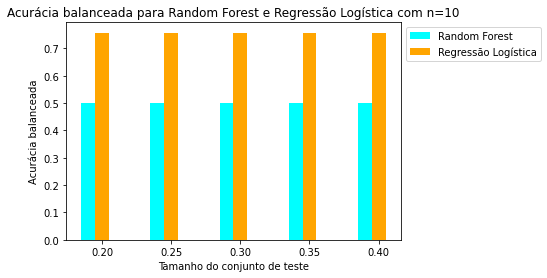

In [67]:
plotar_testSize_accblcd(test_sizes, f10_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=10")

[0.5, 0.5, 0.5, 0.5, 0.5]
[0.723, 0.723, 0.723, 0.723, 0.723]


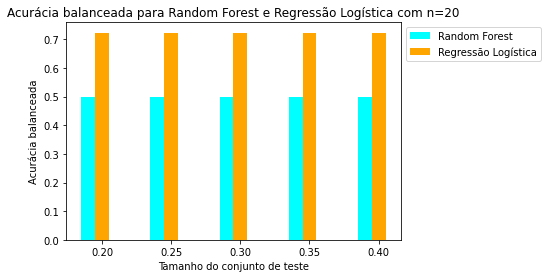

In [68]:
plotar_testSize_accblcd(test_sizes, f20_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=20")

[0.5, 0.5, 0.5, 0.499, 0.5]
[0.685, 0.685, 0.685, 0.685, 0.685]


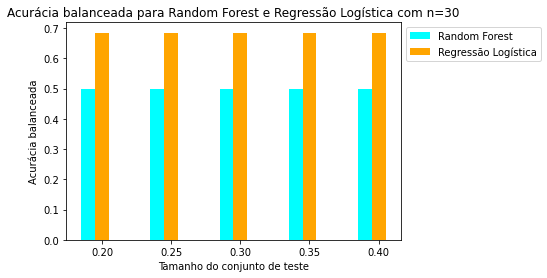

In [69]:
plotar_testSize_accblcd(test_sizes, f30_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=30")

Utilizando scenario02 como treinamento e scenario01 como teste.

In [70]:
metrics_numFeat_model = testes_2bases(caminho_scenario02,caminho_scenario01)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
Index(['START', 'ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 10)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21]
(1121, 10, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0]
[[ 0.04409065]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]
 [-0.0064157 ]]
nan
(1121, 10)
(1121, 17)
(1121, 27)
(55285, 11)
1121
Found 68 unique tokens.
(1121, 10)
(1121, 10, 1)
(62, 1)
administration_of_vaccine_to_produce_active_immunity_(procedure) well_child_visit_(procedure) encounter

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1121
Found 144 unique tokens.
(1121, 10)
(1121, 10, 1)
(160, 1)
nan
nan
(1121, 10)
(1121, 47)
(1121, 57)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 10)
(1121, 10, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 10)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0]
(1174, 10, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0]
[[-0.01192452]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]
 [ 0.0017028 ]]
nan
(1174, 10)
(1174, 17)
(1174, 27)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 10)
(1174, 10, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_care_clinic_(procedure) encounter_for_'check-up' admission_to_skilled_nursing_facility_(procedure) encounter_for_problem stroke patient-initiated_encounter prenatal_initial_visit
death_certification admission_to

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1174
Found 151 unique tokens.
(1174, 10)
(1174, 10, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 10)
(1174, 47)
(1174, 57)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 10)
(1174, 10, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 20)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0]
(1121, 20, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[[-0.02237853]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.02814474]
 [ 0.0281

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1121
Found 144 unique tokens.
(1121, 20)
(1121, 20, 1)
(160, 1)
nan
nan
(1121, 20)
(1121, 77)
(1121, 97)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 20)
(1121, 20, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 20)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(1174, 20, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[[-0.00103335]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]
 [-0.04827349]]
nan
(1174, 20)
(1174, 17)
(1174, 37)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 20)
(1174, 20, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_c

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 20, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 20)
(1174, 77)
(1174, 97)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 20)
(1174, 20, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_yes 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 30)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1121, 30, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[[-0.00241154]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989]
 [ 0.01623989

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 30, 1)
(160, 1)
nan
nan
(1121, 30)
(1121, 107)
(1121, 137)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 30)
(1121, 30, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 30)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1174, 30, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[[-0.00707923]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]
 [-0.04258999]]
nan
(1174, 30)
(1174, 17)
(1174, 47)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 30)
(1174, 30, 1)
(62, 1)
death_certification

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 30, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 30)
(1174, 107)
(1174, 137)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 30)
(1174, 30, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_ye

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

0.4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4


In [71]:
df_metrics_rf_10f = pd.DataFrame(metrics_numFeat_model[0][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_20f = pd.DataFrame(metrics_numFeat_model[1][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_30f = pd.DataFrame(metrics_numFeat_model[2][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])

df_metrics_rl_10f = pd.DataFrame(metrics_numFeat_model[0][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_20f = pd.DataFrame(metrics_numFeat_model[1][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_30f = pd.DataFrame(metrics_numFeat_model[2][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])


In [72]:
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

df_metrics_rf_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_30f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_30f.insert(0, "Test size", test_sizes, True)

In [73]:
f10_models = [metrics_numFeat_model[0][0], metrics_numFeat_model[0][1]] 
f20_models = [metrics_numFeat_model[1][0], metrics_numFeat_model[1][1]] 
f30_models = [metrics_numFeat_model[2][0], metrics_numFeat_model[2][1]]

[0.5, 0.499, 0.5, 0.499, 0.499]
[0.726, 0.726, 0.726, 0.726, 0.726]


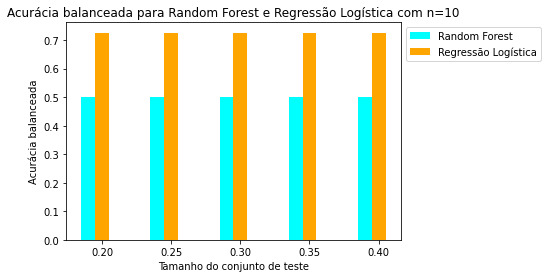

In [74]:
plotar_testSize_accblcd(test_sizes, f10_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=10")

[0.5, 0.5, 0.5, 0.5, 0.5]
[0.806, 0.806, 0.806, 0.806, 0.806]


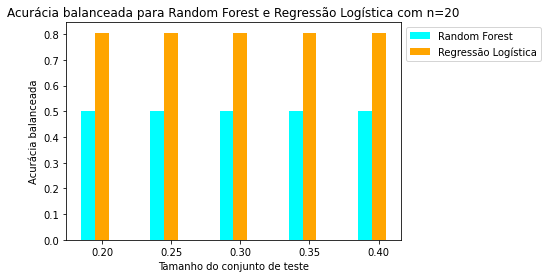

In [75]:
plotar_testSize_accblcd(test_sizes, f20_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=20")

[0.5, 0.498, 0.5, 0.5, 0.5]
[0.751, 0.751, 0.751, 0.751, 0.751]


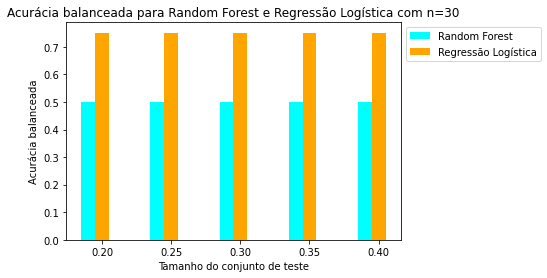

In [76]:
plotar_testSize_accblcd(test_sizes, f30_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=30")

###Scenario01

In [28]:
metrics_numFeat_model = testes(caminho_scenario01)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
Index(['START', 'ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 10)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0]
(1174, 10, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0]
[[0.02131658]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]
 [0.03501934]]
nan
(1174, 10)
(1174, 17)
(1174, 27)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 10)
(1174, 10, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_care_clinic_(procedure) encounter_for_'check-up' admission_to_skilled_nursing_facility_(procedure) encounter_for_problem stroke patient-initiated_encounter prenatal_initial_visit
death_certification admission_to_hospice_ 

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 10, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 10)
(1174, 47)
(1174, 57)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 10)
(1174, 10, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_yes 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 20)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(1174, 20, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[[-0.01395016]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]
 [ 0.01279831]]
nan
(1174, 20)
(1174, 17)
(1174, 37)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 20)
(1174, 20, 1)
(62, 1)
death_certification admission_to_hospice_(procedure) general_examination_of_patient_(procedure) office_visit encounter_for_check_up_(procedure) emergency_encounter encounter_for_symptom emergency_room_admission_(procedure) urgent_c

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 20, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 20)
(1174, 77)
(1174, 97)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 20)
(1174, 20, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_yes 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1174
Found 227 unique tokens.
(1174, 30)
acute_myeloid_leukemia__disease_disorder febrile_neutropenia_disorder bacteremia_finding acute_bronchitis_disorder viral_sinusitis_disorder
[25, 31, 73, 13, 3]
[25 31 73 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1174, 30, 1)
(200, 1)
nan
[76]
[76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[[0.02917309]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]
 [0.04933602]]
nan
(1174, 30)
(1174, 17)
(1174, 47)
(59481, 11)
1174
Found 66 unique tokens.
(1174, 30)
(1174, 30, 1)
(62, 1)
death_certification admission_to_hospice_(procedu

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1174, 30, 1)
(160, 1)
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg/actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
clopidogrel_75_mg_oral_tablet nitroglycerin_0.4_mg actuat_mucosal_spray simvastatin_20_mg_oral_tablet amlodipine_5_mg_oral_tablet donepezil_hydrochloride_23_mg_oral_tablet alendronic_acid_10_mg_oral_tablet levothyroxine_sodium_0.075_mg_oral_tablet
(1174, 30)
(1174, 107)
(1174, 137)
(515299, 9)
(515299, 10)
1174
Found 25641 unique tokens.
(1174, 30)
(1174, 30, 1)
(49000, 1)
cause_of_death_[us_standard_certificate_of_death]_pneumonia total_score_[audit-c]_2.0 patient_health_questionnaire_2_item_(phq-2)_total_score_[reported]_1.0 total_score_[hark]_0.0 fall_risk_total_[morse_fall_scale]_84.0 fall_risk_level_[morse_fall_scale]_high_risk_(mfs_score_50+) in_the_past_year__have_you_been_afraid_of_your_partner_or_ex-partner?_ye

In [28]:
##Todos test_size numFeat==10 random forest
metrics_numFeat_model[0][0][0]

(204.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 31.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0)

In [29]:
df_metrics_rf_10f = pd.DataFrame(metrics_numFeat_model[0][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_20f = pd.DataFrame(metrics_numFeat_model[1][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_30f = pd.DataFrame(metrics_numFeat_model[2][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])

df_metrics_rl_10f = pd.DataFrame(metrics_numFeat_model[0][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_20f = pd.DataFrame(metrics_numFeat_model[1][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_30f = pd.DataFrame(metrics_numFeat_model[2][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])


In [30]:
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

df_metrics_rf_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rf_30f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_10f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_20f.insert(0, "Test size", test_sizes, True)
df_metrics_rl_30f.insert(0, "Test size", test_sizes, True)

In [31]:
df_metrics_rf_10f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,204.0,0.0,0.0,0.0,1.3,0.458,29.7,0.458,1.0,0.0,0.958,0.015,0.979,0.008,0.994,0.002,0.979,0.007
1,0.25,256.0,0.0,0.0,0.0,2.6,0.800,35.4,0.800,1.0,0.0,0.932,0.021,0.964,0.011,0.991,0.003,0.966,0.011
2,0.30,301.0,0.0,0.0,0.0,4.9,0.700,47.1,0.700,1.0,0.0,0.906,0.013,0.950,0.007,0.986,0.002,0.953,0.007
3,0.35,352.0,0.0,0.0,0.0,5.5,0.806,53.5,0.806,1.0,0.0,0.907,0.014,0.951,0.008,0.986,0.002,0.954,0.007
4,0.40,402.0,0.0,0.0,0.0,6.6,1.200,61.4,1.200,1.0,0.0,0.903,0.018,0.949,0.010,0.986,0.002,0.951,0.009


In [32]:
df_metrics_rf_20f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,204.0,0.0,0.0,0.0,1.7,0.640,29.3,0.640,1.0,0.0,0.945,0.021,0.972,0.011,0.993,0.003,0.973,0.010
1,0.25,256.0,0.0,0.0,0.0,3.4,0.490,34.6,0.490,1.0,0.0,0.911,0.013,0.953,0.007,0.988,0.002,0.955,0.007
2,0.30,301.0,0.0,0.0,0.0,5.9,0.539,46.1,0.539,1.0,0.0,0.887,0.010,0.940,0.006,0.983,0.002,0.943,0.005
3,0.35,352.0,0.0,0.0,0.0,8.3,0.900,50.7,0.900,1.0,0.0,0.859,0.015,0.924,0.009,0.980,0.002,0.930,0.007
4,0.40,402.0,0.0,0.0,0.0,7.8,1.327,60.2,1.327,1.0,0.0,0.885,0.019,0.939,0.011,0.983,0.003,0.943,0.010


In [33]:
df_metrics_rf_30f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,204.0,0.0,0.0,0.0,1.6,0.663,29.4,0.663,1.000,0.000,0.948,0.022,0.974,0.011,0.993,0.003,0.974,0.011
1,0.25,255.9,0.3,0.1,0.3,2.1,0.300,35.9,0.300,0.997,0.008,0.944,0.008,0.970,0.005,0.992,0.001,0.972,0.004
2,0.30,301.0,0.0,0.0,0.0,4.7,0.640,47.3,0.640,1.000,0.000,0.910,0.012,0.952,0.007,0.987,0.002,0.955,0.006
3,0.35,352.0,0.0,0.0,0.0,8.7,1.792,50.3,1.792,1.000,0.000,0.852,0.030,0.920,0.018,0.979,0.004,0.927,0.015
4,0.40,401.1,0.7,0.9,0.7,11.2,1.400,56.8,1.400,0.984,0.012,0.836,0.021,0.904,0.016,0.974,0.004,0.917,0.011


In [34]:
df_metrics_rl_10f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,178.0,0.0,26.0,0.0,5.0,0.0,26.0,0.0,0.500,0.0,0.839,0.0,0.627,0.0,0.868,0.0,0.856,0.0
1,0.25,228.0,0.0,28.0,0.0,7.0,0.0,31.0,0.0,0.525,0.0,0.816,0.0,0.639,0.0,0.881,0.0,0.853,0.0
2,0.30,264.0,0.0,37.0,0.0,13.0,0.0,39.0,0.0,0.513,0.0,0.750,0.0,0.609,0.0,0.858,0.0,0.814,0.0
3,0.35,307.0,0.0,45.0,0.0,14.0,0.0,45.0,0.0,0.500,0.0,0.763,0.0,0.604,0.0,0.856,0.0,0.817,0.0
4,0.40,345.0,0.0,57.0,0.0,16.0,0.0,52.0,0.0,0.477,0.0,0.765,0.0,0.588,0.0,0.845,0.0,0.811,0.0


In [35]:
df_metrics_rl_20f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,181.0,0.0,23.0,0.0,4.0,0.0,27.0,0.0,0.540,0.0,0.871,0.0,0.667,0.0,0.885,0.0,0.879,0.0
1,0.25,229.0,0.0,27.0,0.0,6.0,0.0,32.0,0.0,0.542,0.0,0.842,0.0,0.660,0.0,0.888,0.0,0.868,0.0
2,0.30,263.0,0.0,38.0,0.0,11.0,0.0,41.0,0.0,0.519,0.0,0.788,0.0,0.626,0.0,0.861,0.0,0.831,0.0
3,0.35,309.0,0.0,43.0,0.0,13.0,0.0,46.0,0.0,0.517,0.0,0.780,0.0,0.622,0.0,0.864,0.0,0.829,0.0
4,0.40,349.0,0.0,53.0,0.0,15.0,0.0,53.0,0.0,0.500,0.0,0.779,0.0,0.609,0.0,0.855,0.0,0.824,0.0


In [36]:
df_metrics_rl_30f

,Test size,tn_mean,std tn,fp_mean,std fp,fn_mean,std fn,tp_mean,std tp,precision_mean,std precision_mean,recall_mean,std recall_mean,F1_score_mean,std F1_score_mean,accuracy_mean,std accuracy_mean,acc_balanced_mean,std acc_balanced_mean
0,0.20,182.0,0.0,22.0,0.0,4.0,0.0,27.0,0.0,0.551,0.0,0.871,0.0,0.675,0.0,0.889,0.0,0.882,0.0
1,0.25,232.0,0.0,24.0,0.0,6.0,0.0,32.0,0.0,0.571,0.0,0.842,0.0,0.681,0.0,0.898,0.0,0.874,0.0
2,0.30,264.0,0.0,37.0,0.0,11.0,0.0,41.0,0.0,0.526,0.0,0.788,0.0,0.631,0.0,0.864,0.0,0.833,0.0
3,0.35,308.0,0.0,44.0,0.0,12.0,0.0,47.0,0.0,0.516,0.0,0.797,0.0,0.627,0.0,0.864,0.0,0.836,0.0
4,0.40,346.0,0.0,56.0,0.0,16.0,0.0,52.0,0.0,0.481,0.0,0.765,0.0,0.591,0.0,0.847,0.0,0.813,0.0


In [37]:
f10_models = [metrics_numFeat_model[0][0], metrics_numFeat_model[0][1]] 
f20_models = [metrics_numFeat_model[1][0], metrics_numFeat_model[1][1]] 
f30_models = [metrics_numFeat_model[2][0], metrics_numFeat_model[2][1]]

[0.979, 0.966, 0.953, 0.954, 0.951]
[0.856, 0.853, 0.814, 0.817, 0.811]


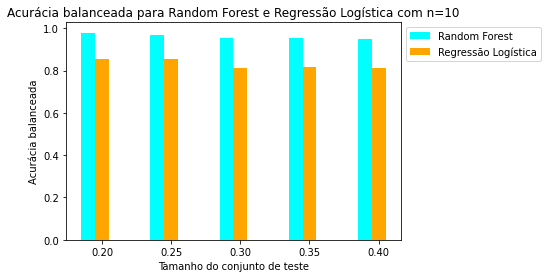

In [39]:
plotar_testSize_accblcd(test_sizes, f10_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=10")

[0.973, 0.955, 0.943, 0.93, 0.943]
[0.879, 0.868, 0.831, 0.829, 0.824]


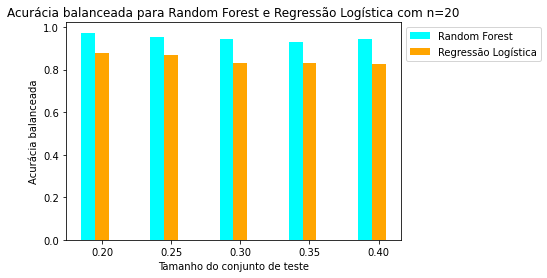

In [43]:
plotar_testSize_accblcd(test_sizes, f20_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=20")

[0.974, 0.972, 0.955, 0.927, 0.917]
[0.882, 0.874, 0.833, 0.836, 0.813]


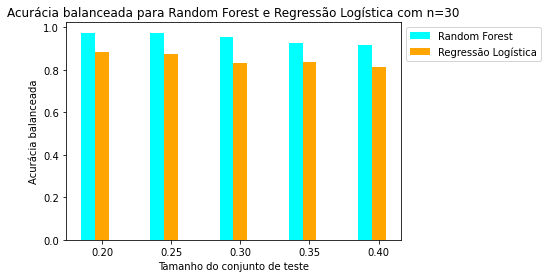

In [44]:
plotar_testSize_accblcd(test_sizes, f30_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=30")

In [47]:
matriz_confusao_10_rf = [[df_metrics_rf_10f['tp_mean'][0], df_metrics_rf_10f['fp_mean'][0]],
                   [df_metrics_rf_10f['fn_mean'][0], round(df_metrics_rf_10f['tn_mean'][0],1)]]

matriz_confusao_20_rf = [[df_metrics_rf_20f['tp_mean'][0], df_metrics_rf_20f['fp_mean'][0]],
                   [df_metrics_rf_20f['fn_mean'][0], round(df_metrics_rf_20f['tn_mean'][0],1)]]

matriz_confusao_30_rf = [[df_metrics_rf_30f['tp_mean'][0], df_metrics_rf_30f['fp_mean'][0]],
                   [df_metrics_rf_30f['fn_mean'][0], round(df_metrics_rf_30f['tn_mean'][0],1)]]                   

In [49]:
matriz_confusao_10_rl = [[df_metrics_rl_10f['tp_mean'][0], df_metrics_rl_10f['fp_mean'][0]],
                   [df_metrics_rl_10f['fn_mean'][0], round(df_metrics_rl_10f['tn_mean'][0],1)]]

matriz_confusao_20_rl = [[df_metrics_rl_20f['tp_mean'][0], df_metrics_rl_20f['fp_mean'][0]],
                   [df_metrics_rl_20f['fn_mean'][0], round(df_metrics_rl_20f['tn_mean'][0],1)]]

matriz_confusao_30_rl = [[df_metrics_rl_30f['tp_mean'][0], df_metrics_rl_30f['fp_mean'][0]],
                   [df_metrics_rl_30f['fn_mean'][0], round(df_metrics_rl_30f['tn_mean'][0],1)]]                   

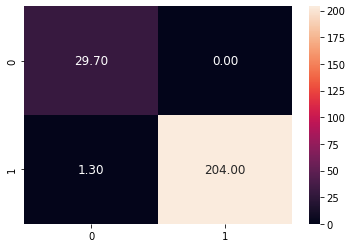

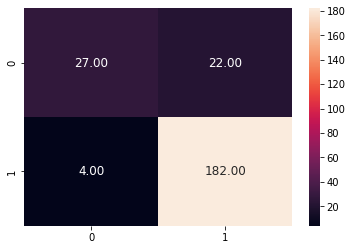

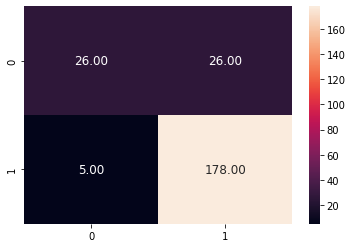

In [51]:
plot_matriz_confusao(matriz_confusao_10_rf)
#plot_matriz_confusao(matriz_confusao_20_rf)
#plot_matriz_confusao(matriz_confusao_30_rf)
plot_matriz_confusao(matriz_confusao_30_rl)
plot_matriz_confusao(matriz_confusao_10_rl)

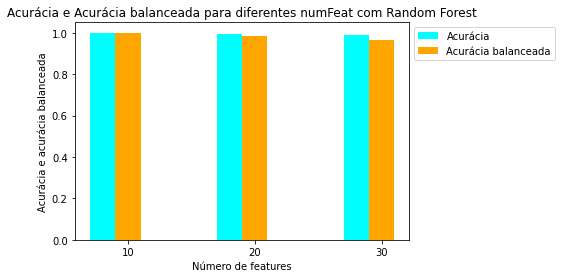

In [66]:
plotar_acc_acc_blcd([10,20,30], df_metrics_rf_10f, df_metrics_rf_20f, df_metrics_rf_30f, 0, "Acurácia e Acurácia balanceada para diferentes numFeat com Random Forest")

###Scenario02

In [29]:
caminho_scenario02  = '/content/drive/MyDrive/2022-1Semestre/Ciencia-Dados-Saude/trabalho2/data/external/synthea/scenario02/csv/'
metrics_numFeat_model = testes(caminho_scenario02)

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'RACE', 'ETHNICITY',
       'GENDER', 'LAT', 'LON'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
Index(['START', 'ST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 10)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21]
(1121, 10, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0]
[[0.03305784]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]
 [0.01615863]]
nan
(1121, 10)
(1121, 17)
(1121, 27)
(55285, 11)
1121
Found 68 unique tokens.
(1121, 10)
(1121, 10, 1)
(62, 1)
administration_of_vaccine_to_produce_active_immunity_(procedure) well_child_visit_(procedure) encounter_for_sympt

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 10, 1)
(160, 1)
nan
nan
(1121, 10)
(1121, 47)
(1121, 57)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 10)
(1121, 10, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


1121
Found 218 unique tokens.
(1121, 20)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0]
(1121, 20, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[[ 0.03908422]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292433 ]
 [-0.0292

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(1121, 20, 1)
(160, 1)
nan
nan
(1121, 20)
(1121, 77)
(1121, 97)
(474132, 9)
(474132, 10)
1121
Found 24854 unique tokens.
(1121, 20)
(1121, 20, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


Found 218 unique tokens.
(1121, 30)
full-time_employment_finding limited_social_contact_finding reports_of_violence_in_the_environment_finding acute_bronchitis_disorder stress_finding acute_viral_pharyngitis_disorder viral_sinusitis_disorder antepartum_eclampsia part-time_employment_finding normal_pregnancy not_in_labor_force_finding received_higher_education_finding risk_activity_involvement_finding seizure_disorder history_of_single_seizure_situation epilepsy
[2, 5, 14, 9, 1, 8, 3, 89, 4, 21, 7, 15, 19, 52, 53, 73]
[ 2  5 14  9  1  8  3 89  4 21  7 15 19 52 53 73  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
(1121, 30, 1)
(200, 1)
nan
[125]
[125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[[ 0.03731896]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-0.03452514]
 [-

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(474132, 10)
1121
Found 24854 unique tokens.
(1121, 30)
(1121, 30, 1)
(49000, 1)
patient_health_questionnaire-9:_modified_for_teens_total_score_[reported.phq.teen]_1.0 generalized_anxiety_disorder_7_item_(gad-7)_total_score_[reported.phq]_8.0 body_height_140.7 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_4.0 body_weight_37.6 body_mass_index_19.0 body_mass_index_(bmi)_[percentile]_per_age_and_gender_67.5 diastolic_blood_pressure_78.0 systolic_blood_pressure_119.0 heart_rate_83.0 respiratory_rate_15.0 tobacco_smoking_status_nhis_never_smoker qaly_11.0 daly_0.0 qols_1.0 body_height_135.6 pain_severity_-_0-10_verbal_numeric_rating_[score]_-_reported_1.0 body_weight_34.7 body_mass_index_18.9 body_mass_index_(bmi)_[percentile]_per_age_and_gender_74.2 systolic_blood_pressure_114.0 heart_rate_63.0 respiratory_rate_13.0 leukocytes_[#/volume]_in_blood_by_automated_count_5.4 erythrocytes_[#/volume]_in_blood_by_automated_count_4.8 hemoglobin_[mass/volume]_in_blood_17.1 hematocrit_

In [30]:
df_metrics_rf_10f = pd.DataFrame(metrics_numFeat_model[0][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_20f = pd.DataFrame(metrics_numFeat_model[1][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rf_30f = pd.DataFrame(metrics_numFeat_model[2][0], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])

df_metrics_rl_10f = pd.DataFrame(metrics_numFeat_model[0][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_20f = pd.DataFrame(metrics_numFeat_model[1][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])
df_metrics_rl_30f = pd.DataFrame(metrics_numFeat_model[2][1], columns = ['tn_mean', 'std tn', 'fp_mean', 'std fp', 'fn_mean', 'std fn','tp_mean','std tp', 'precision_mean', 'std precision_mean','recall_mean', 'std recall_mean','F1_score_mean', 'std F1_score_mean','accuracy_mean','std accuracy_mean', 'acc_balanced_mean', 'std acc_balanced_mean'])


In [31]:
f10_models = [metrics_numFeat_model[0][0], metrics_numFeat_model[0][1]] 
f20_models = [metrics_numFeat_model[1][0], metrics_numFeat_model[1][1]] 
f30_models = [metrics_numFeat_model[2][0], metrics_numFeat_model[2][1]]

[0.959, 0.958, 0.966, 0.959, 0.938]
[0.749, 0.783, 0.766, 0.755, 0.763]


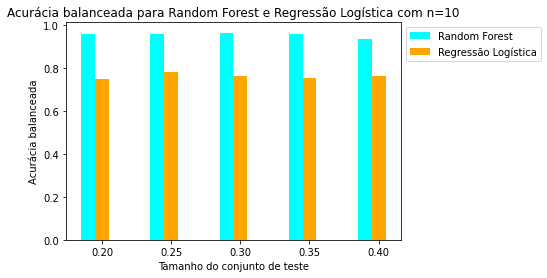

In [33]:
test_sizes= [0.2,0.25,0.3,0.35,0.4]
plotar_testSize_accblcd(test_sizes, f10_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=10")

[0.948, 0.933, 0.912, 0.923, 0.923]
[0.781, 0.787, 0.792, 0.77, 0.775]


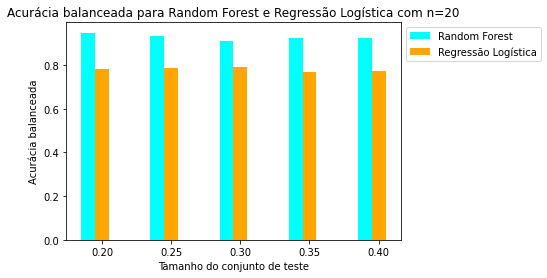

In [34]:
plotar_testSize_accblcd(test_sizes, f20_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=20")

[0.917, 0.924, 0.891, 0.895, 0.874]
[0.762, 0.771, 0.772, 0.761, 0.769]


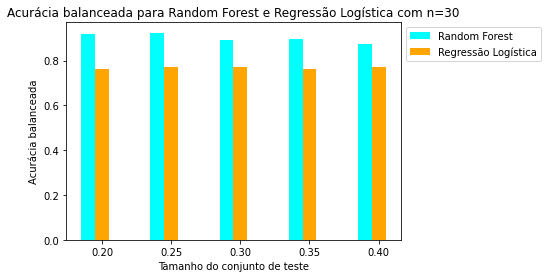

In [36]:
plotar_testSize_accblcd(test_sizes, f30_models, "Acurácia balanceada para Random Forest e Regressão Logística com n=30")

##Visualização

In [52]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ce3693564f70566d1b9842439079b562a807737c5135e97f649122329a102230
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=7f136b7e9eae7573f82d1fa829bb51a5c7a05002cb54c3fa16a4c44c3897242a
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [53]:
import umap

In [56]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform(X=X_scenario,y=None)
embedding.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(1174, 2)

In [57]:
print(embedding)

[[16.168633    8.519004  ]
 [16.12366     8.5869055 ]
 [15.748921    8.362241  ]
 ...
 [ 8.914867   -0.90460163]
 [ 9.099      -1.3345954 ]
 [ 8.980956   -0.95823646]]


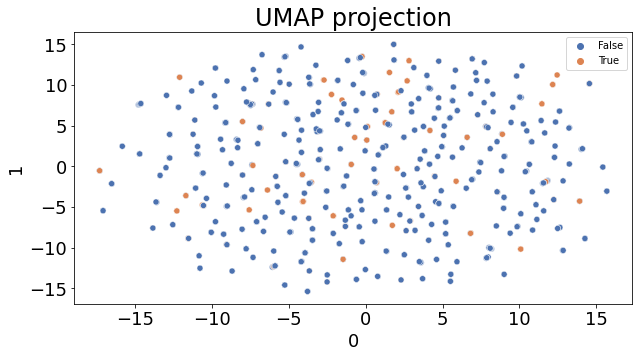

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))

ax = sns.scatterplot(data=embedding, x=embedding[:,0], y=embedding[:,1], hue=y_scenario, palette="deep")


plt.xlabel('0',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('1',fontsize=18)
plt.yticks(fontsize=18)


plt.title('UMAP projection', fontsize=24)
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(10, 5)

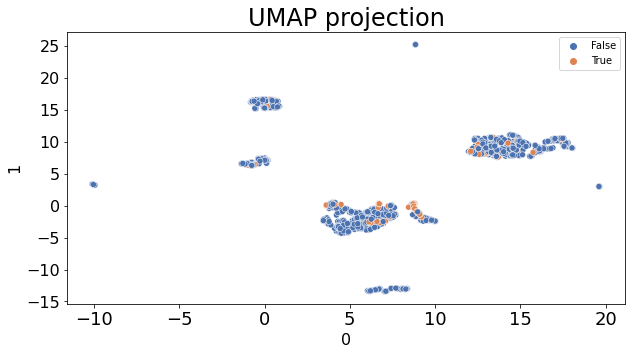

In [58]:
import seaborn as sns
plt.figure(figsize=(15,15))

ax = sns.scatterplot(data=embedding, x=embedding[:,0], y=embedding[:,1], hue=y_scenario, palette="deep")


plt.xlabel('0',fontsize=16)
plt.xticks(fontsize=18)
plt.ylabel('1',fontsize=16)
plt.yticks(fontsize=16)


plt.title('UMAP projection', fontsize=24)
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(10, 5)

##Busca por parâmetros dos modelos

In [ ]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
param_grid = {'max_depth': [3, 5, 10, 15, 20],
               'min_samples_split': [2, 5, 10]}
base_estimator = RandomForestClassifier(random_state=0)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_estimators',max_resources=30).fit(X_scenario, y_scenario)
sh.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=24,
                       random_state=0)

In [ ]:
models = [RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=24,random_state=0)]
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

trial_count = 30
metrics_model = []
metrics_test_size = []
for model in models:
  print(model)
  for test_s in test_sizes:
    print(test_s)
    
    metrics_test_size.append(script(trial_count, X_scenario, y_scenario, model, test_s))
  
  metrics_model.append(metrics_test_size)
  metrics_test_size = []

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=24,
                       random_state=0)
0.2
0.25
0.3
0.35
0.4


[0.9349999999999998, 0.9209999999999998, 0.933, 0.9319999999999998, 0.9340000000000003]


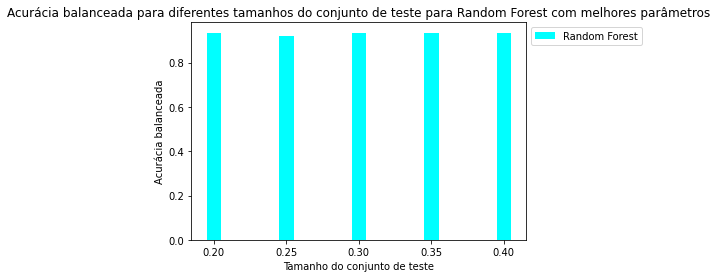

In [ ]:
plotar_testSize_accblcd_1modelo(test_sizes, metrics_model, "Random Forest", "Acurácia balanceada para diferentes tamanhos do conjunto de teste para Random Forest com melhores parâmetros")

In [ ]:
models = [RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=24, random_state=0)]
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

trial_count = 30
metrics_model = []
metrics_test_size = []
for model in models:
  print(model)
  for test_s in test_sizes:
    print(test_s)
    
    metrics_test_size.append(script(trial_count, X_scenario, y_scenario, model, test_s))
  
  metrics_model.append(metrics_test_size)
  metrics_test_size = []

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=24,
                       random_state=0)
0.2
0.25
0.3
0.35
0.4


[0.914, 0.9530000000000001, 0.9500000000000002, 0.9620000000000001, 0.963]


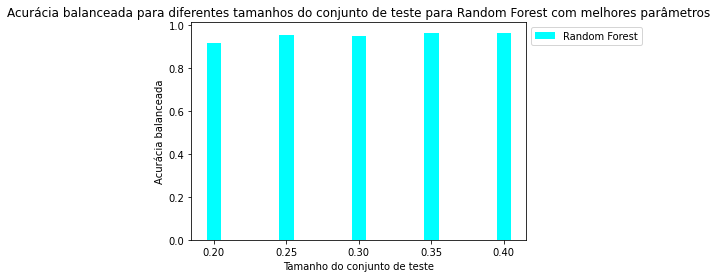

In [ ]:
plotar_testSize_accblcd_1modelo(test_sizes, metrics_model, "Random Forest", "Acurácia balanceada para diferentes tamanhos do conjunto de teste para Random Forest com melhores parâmetros")

##Verifica overfitting

In [ ]:
models = [RandomForestClassifier(class_weight = 'balanced'), LogisticRegression(class_weight = 'balanced')]
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

trial_count = 50
metrics_model = []
metrics_test_size = []
for model in models:
  print(model)
  for test_s in test_sizes:
    print(test_s)
    
    metrics_test_size.append(script_overfitting(trial_count, X_scenario, y_scenario, model, test_s))
  
  metrics_model.append(metrics_test_size)
  metrics_test_size = []

RandomForestClassifier(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4
LogisticRegression(class_weight='balanced')
0.2
0.25
0.3
0.35
0.4


[1.0, 1.0, 1.0, 1.0, 1.0]
[0.796, 0.796, 0.801, 0.8029999999999999, 0.8149999999999997]


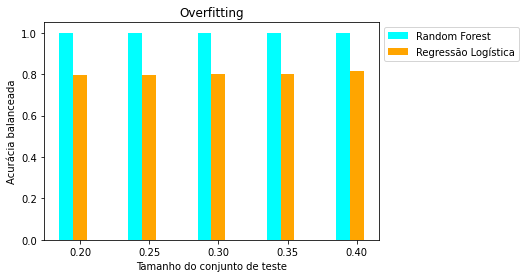

In [ ]:
plotar_testSize_accblcd(test_sizes, metrics_model, "Overfitting")

In [ ]:
models = [RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=24, random_state=0)]
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4]

trial_count = 50
metrics_model = []
metrics_test_size = []
for model in models:
  print(model)
  for test_s in test_sizes:
    print(test_s)
    
    metrics_test_size.append(script_overfitting(trial_count, X_scenario, y_scenario, model, test_s))
  
  metrics_model.append(metrics_test_size)
  metrics_test_size = []

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=24,
                       random_state=0)
0.2
0.25
0.3
0.35
0.4


[0.997, 0.9960000000000002, 0.9960000000000002, 0.9960000000000002, 0.9949999999999999]


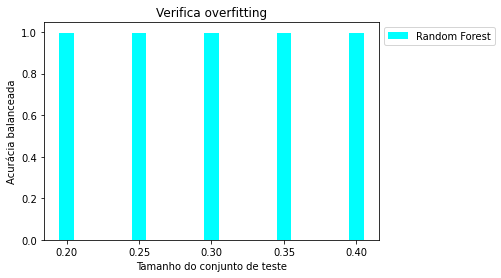

In [ ]:
plotar_testSize_accblcd_1modelo(test_sizes, metrics_model, "Random Forest" ,"Verifica overfitting")